# Understanding word vectors

... for, like, actual poets. By [Allison Parrish](http://www.decontextualize.com/)

In this tutorial, I'm going to show you how word vectors work.

In [2]:
import sys
!{sys.executable} -m pip install matplotlib

In [3]:
import sys
!{sys.executable} -m pip install panda

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pd.set_option('max_rows', 25)
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

## Why word vectors for poetry?

Tzara proposed a method of composing a Dada poem: cut out the words of a text, shake them in a bag, then write down the words as you remove them at random from the bag. The very idea caused a riot and sundered the avant garde in twain (or so the story goes). For poets, word vectors are (for better or worse) a tool to help soften the blow of cut-up techniques: instead of selecting words at random, we might select units of text that are *close in meaning* to other units. This can yield poetic juxtapositions with subtle effects impossible to achieve with other techniques.

Also, it's fun!

## Animal similarity and simple linear algebra

We'll begin by considering a small subset of English: words for animals. Our task is to be able to write computer programs to find similarities among these words and the creatures they designate. To do this, we might start by making a spreadsheet of some animals and their characteristics. In Python, you'd define such a spreadsheet like this:

In [5]:
animals = [
    {'name': 'kitten', 'cuteness': 95, 'size': 15},
    {'name': 'hamster', 'cuteness': 80, 'size': 8},
    {'name': 'tarantula', 'cuteness': 8, 'size': 3},
    {'name': 'puppy', 'cuteness': 90, 'size': 20},
    {'name': 'crocodile', 'cuteness': 5, 'size': 40},
    {'name': 'dolphin', 'cuteness': 60, 'size': 45},
    {'name': 'panda bear', 'cuteness': 75, 'size': 40},
    {'name': 'lobster', 'cuteness': 2, 'size': 15},
    {'name': 'capybara', 'cuteness': 70, 'size': 30},
    {'name': 'elephant', 'cuteness': 65, 'size': 90},
    {'name': 'mosquito', 'cuteness': 1, 'size': 1},
    {'name': 'goldfish', 'cuteness': 25, 'size': 2},
    {'name': 'horse', 'cuteness': 50, 'size': 50},
    {'name': 'chicken', 'cuteness': 25, 'size': 15}
]
animal_lookup = {item['name']: (item['cuteness'], item['size']) for item in animals}

And then display it:

In [6]:
pd.DataFrame(animals, columns=['name', 'cuteness', 'size'])

,name,cuteness,size
0,kitten,95,15
1,hamster,80,8
2,tarantula,8,3
3,puppy,90,20
4,crocodile,5,40
5,dolphin,60,45
6,panda bear,75,40
7,lobster,2,15
8,capybara,70,30
9,elephant,65,90


This table associates a handful of animals with two numbers: their cuteness and their size, both in a range from zero to one hundred. (The values themselves are simply based on my own judgment. Your taste in cuteness and evaluation of size may differ significantly from mine. As with all data, these data are simply a mirror reflection of the person who collected them.)

These values give us everything we need to make determinations about which animals are similar (at least, similar in the properties that we've included in the data). Try to answer the following question: Which animal is most similar to a capybara? You could go through the values one by one and do the math to make that evaluation, but visualizing the data as points in 2-dimensional space makes finding the answer very intuitive:

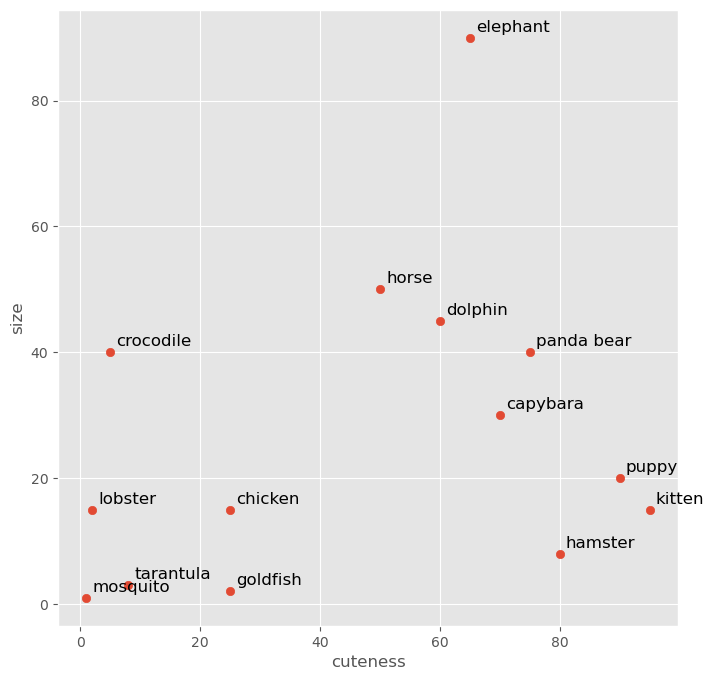

In [8]:
plt.figure(figsize=(8, 8))
plt.scatter([item[0] for item in animal_lookup.values()],
            [item[1] for item in animal_lookup.values()])
plt.xlabel('cuteness')
plt.ylabel('size')
for label, (cute, size) in animal_lookup.items():
    plt.text(cute+1, size+1, label, fontsize=12)
plt.show()

The plot shows us that the closest animal to the capybara is the panda bear (again, in terms of its subjective size and cuteness). One way of calculating how "far apart" two points are is to find their *Euclidean distance*. (This is simply the length of the line that connects the two points.) For points in two dimensions, Euclidean distance can be calculated with the following Python function:

In [9]:
import math
def distance2d(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

(The `**` operator raises the value on its left to the power on its right.)

So, the distance between "capybara" (70, 30) and "panda" (74, 40):

In [10]:
distance2d(animal_lookup['capybara'], animal_lookup['panda bear']) # panda and capybara

11.180339887498949

... is less than the distance between "tarantula" and "elephant":

In [11]:
distance2d(animal_lookup['tarantula'], animal_lookup['elephant']) # tarantula and elephant

104.0096149401583

Modeling animals in this way has a few other interesting properties. For example, you can pick an arbitrary point in "animal space" and then find the animal closest to that point. If you imagine an animal of size 25 and cuteness 30, you can easily look at the space to find the animal that most closely fits that description: the chicken.

Reasoning visually, you can also answer questions like: what's halfway between a chicken and an elephant? Simply draw a line from "elephant" to "chicken," mark off the midpoint and find the closest animal. (According to our chart, halfway between an elephant and a chicken is a horse.)

You can also ask: what's the *difference* between a hamster and a tarantula? According to our plot, it's about seventy five units of cute (and a few units of size).

The relationship of "difference" is an interesting one, because it allows us to reason about *analogous* relationships. In the chart below, I've drawn an arrow from "tarantula" to "hamster" (in blue):

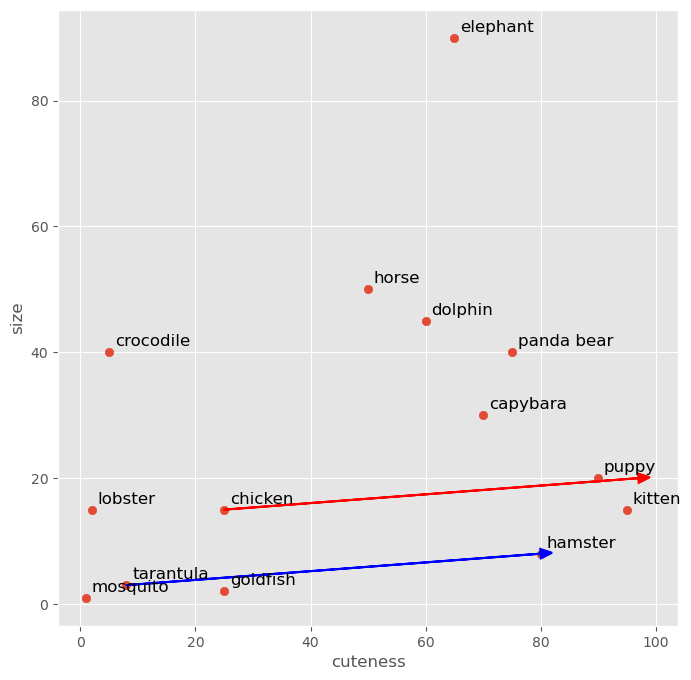

In [12]:
plt.figure(figsize=(8, 8))
plt.scatter([item[0] for item in animal_lookup.values()],
            [item[1] for item in animal_lookup.values()])
plt.xlabel('cuteness')
plt.ylabel('size')
for label, (cute, size) in animal_lookup.items():
    plt.text(cute+1, size+1, label, fontsize=12)
plt.arrow(
    *(animal_lookup['tarantula']),
    *(np.array(animal_lookup['hamster']) - np.array(animal_lookup['tarantula'])),
    fc="b", ec="b", head_width=1.5, head_length=2, linewidth=1.5)
plt.arrow(
    *(animal_lookup['chicken']),
    *(np.array(animal_lookup['hamster']) - np.array(animal_lookup['tarantula'])),
    fc="r", ec="r", head_width=1.5, head_length=2, linewidth=1.5)
plt.show()

You can understand this arrow as being the *relationship* between a tarantula and a hamster, in terms of their size and cuteness (i.e., hamsters and tarantulas are about the same size, but hamsters are much cuter). In the same diagram, I've also transposed this same arrow (this time in red) so that its origin point is "chicken." The arrow ends closest to "kitten." What we've discovered is that the animal that is about the same size as a chicken but much cuter is... a kitten. To put it in terms of an analogy:

    Tarantulas are to hamsters as chickens are to kittens.
    
A sequence of numbers used to identify a point is called a *vector*, and the kind of math we've been doing so far is called *linear algebra.* (Linear algebra is surprisingly useful across many domains: It's the same kind of math you might do to, e.g., simulate the velocity and acceleration of a sprite in a video game.)

A set of vectors that are all part of the same data set is often called a *vector space*. The vector space of animals in this section has two *dimensions*, by which I mean that each vector in the space has two numbers associated with it (i.e., two columns in the spreadsheet). The fact that this space has two dimensions just happens to make it easy to *visualize* the space by drawing a 2D plot. But most vector spaces you'll work with will have more than two dimensions—sometimes many hundreds. In those cases, it's more difficult to visualize the "space," but the math works pretty much the same.

## Language with vectors: colors

So far, so good. We have a system in place—albeit highly subjective—for talking about animals and the words used to name them. I want to talk about another vector space that has to do with language: the vector space of colors.

Colors are often represented in computers as vectors with three dimensions: red, green, and blue. Just as with the animals in the previous section, we can use these vectors to answer questions like: which colors are similar? What's the most likely color name for an arbitrarily chosen set of values for red, green and blue? Given the names of two colors, what's the name of those colors' "average"?

We'll be working with this [color data](https://github.com/dariusk/corpora/blob/master/data/colors/xkcd.json) from the [xkcd color survey](https://blog.xkcd.com/2010/05/03/color-survey-results/). The data relates a color name to the RGB value associated with that color. [Here's a page that shows what the colors look like](https://xkcd.com/color/rgb/). Download the color data and put it in the same directory as this notebook.

A few notes before we proceed:

* We're using `numpy` arrays below to implement vector arithmetic. You'll need to install `numpy` to get the examples to work. (If you used Anaconda to install Python, you have `numpy` already.) [Here's a quick introduction on how to use numpy for vector arithmetic.](https://docs.scipy.org/doc/numpy/user/quickstart.html)
* If you're interested in perceptually accurate color math in Python, consider using the [colormath library](http://python-colormath.readthedocs.io/en/latest/).

Now, import the `json` library and load the color data:

In [13]:
import json

In [14]:
color_data = json.loads(open("xkcd.json").read())

The following function converts colors from hex format (`#1a2b3c`) to a tuple of integers:

In [15]:
def hex_to_int(s):
    s = s.lstrip("#")
    return np.array([int(s[:2], 16), int(s[2:4], 16), int(s[4:6], 16)])

And the following cell creates a dictionary and populates it with mappings from color names to RGB vectors for each color in the data:

In [16]:
colors = dict()
for item in color_data['colors']:
    colors[item["color"]] = hex_to_int(item["hex"])

Testing it out:

In [17]:
colors['olive']

array([110, 117,  14])

In [18]:
colors['red']

array([229,   0,   0])

In [19]:
colors['black']

array([0, 0, 0])

In [20]:
colors['cyan']

array([  0, 255, 255])

### Vector math

Before we keep going, we'll need some functions for performing basic vector "arithmetic." These functions will work with vectors in spaces of any number of dimensions.

The first function returns the Euclidean distance between two points:

In [21]:
from numpy.linalg import norm
def distance(a, b):
    return norm(a - b)

In [22]:
distance(colors['cyan'], colors['blue'])

190.7275543805876

In [23]:
distance(np.array([10, 1]), np.array([5, 2]))

5.0990195135927845

Subtracting vectors:

In [24]:
colors['cyan'] - colors['blue']

array([ -3, 188,  32])

Adding vectors:

In [25]:
colors['cyan'] + colors['blue']

array([  3, 322, 478])

You can find the average of two vectors using the expected formula:

In [26]:
(colors['cyan'] + colors['blue']) / 2

array([  1.5, 161. , 239. ])

Or use the following function, which finds the mean of any number of vectors:

In [27]:
def meanv(vecs):
    total = np.sum(vecs, axis=0)
    return total / len(vecs)

In [28]:
meanv([colors['red'], colors['pink'], colors['maroon']])

array([195.,  43.,  75.])

Just as a test, the following cell shows that the distance from "red" to "green" is greater than the distance from "red" to "pink":

In [29]:
distance(colors['red'], colors['green']) > distance(colors['red'], colors['pink'])

True

### Finding the closest item

Just as we wanted to find the animal that most closely matched an arbitrary point in cuteness/size space, we'll want to find the closest color name to an arbitrary point in RGB space. The easiest way to find the closest item to an arbitrary vector is simply to find the distance between the target vector and each item in the space, in turn, then sort the list from closest to most distant.

Calculating the distance between two points, however, is computationally expensive, especially when you're working with data that has many dimensions. To solve this problem, computer scientists and mathematicians came up with the idea of [approximate nearest neighbor search](https://en.wikipedia.org/wiki/Nearest_neighbor_search#Approximation_methods), a technique for finding similar points in high-dimensional spaces that make use of various tricks to speed up the process (potentially at the cost of accuracy).

We're going to use a library I made called [Simple Neighbors](https://github.com/aparrish/simpleneighbors) that builds such an approximate nearest neighbors index to quickly return the closest items for any given vector. (Simple Neighbors is based on [Annoy](https://pypi.python.org/pypi/annoy).)

Install Simple Neighbors like so:

In [30]:
import sys
!{sys.executable} -m pip install simpleneighbors

You'll want to install Annoy as well, to speed up the nearest neighbor search. As of this writing, I recommend Annoy 1.16.3:

In [31]:
import sys
!{sys.executable} -m pip install annoy==1.16.3

  Using cached annoy-1.16.3.tar.gz (644 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [24 lines of output]
      /Users/pien/anaconda3/lib/python3.11/site-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.0-arm64-cpython-311
      creating build/lib.macosx-11.0-arm64-

If you get an error from the above, and you're using Anaconda, you can try installing the Anaconda package:

In [32]:
import sys
!conda install -y --prefix {sys.prefix} -c conda-forge python-annoy 

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



# All requested packages already installed.



If neither of those works—especially if you're using Windows—you may need to install a C++ compiler, or you can use this notebook on Binder. (If you're a student, come see me for more info.)

Once you have the library installed, import it like so:

In [33]:
from simpleneighbors import SimpleNeighbors

The first parameter to `SimpleNeighbors()` is the number of dimensions in the data; the second is the distance metric to use. (This defaults to cosine distance, but in this case we want to use Euclidean distance.)

The `.add_one()` method adds an item and a vector to the index. Once all the items are added, `.build()` actually builds the index. This should go quick, since we don't have that much data!

In [40]:
color_lookup = SimpleNeighbors(3, 'euclidean')
for name, vec in colors.items():
    color_lookup.add_one(name, vec)
color_lookup.build()

To find the nearest item to a specified vector, pass the vector to the `.nearest()` method:

In [41]:
colors['red']

array([229,   0,   0])

In [44]:
color_lookup.nearest(colors['red'])

['red',
 'fire engine red',
 'bright red',
 'tomato red',
 'cherry red',
 'scarlet',
 'vermillion',
 'orangish red',
 'cherry',
 'lipstick red',
 'darkish red',
 'neon red']

Limit the number of results returned with the second parameter:

In [33]:
color_lookup.nearest(colors['red'], 3)

['red', 'fire engine red', 'bright red']

Here are the colors closest to (150, 60, 150):

In [47]:
import random
random.randrange(256)

108

In [34]:
color_lookup.nearest([150, 60, 150])

['warm purple',
 'medium purple',
 'ugly purple',
 'light eggplant',
 'purpleish',
 'purplish',
 'purply',
 'light plum',
 'purple',
 'muted purple',
 'dull purple',
 'dusty purple']

The `.dist()` method gives the distance between two items in the index:

In [35]:
color_lookup.dist('rose', 'pink')

94.28679656982422

In [36]:
color_lookup.dist('green', 'purple')

221.90313720703125

And you can check the `.corpus` attribute to see if an item is even in the index to begin with:

In [37]:
'orange' in color_lookup.corpus

True

In [38]:
'kitten' in color_lookup.corpus

False

### Color magic

The magical part of representing words as vectors is that the vector operations we defined earlier appear to operate on language the same way they operate on numbers. For example, if we find the word closest to the vector resulting from subtracting "red" from "purple," we get a series of "blue" colors:

In [39]:
color_lookup.nearest(colors['purple'] - colors['red'])

['cobalt blue',
 'royal blue',
 'darkish blue',
 'true blue',
 'royal',
 'prussian blue',
 'dark royal blue',
 'deep blue',
 'marine blue',
 'deep sea blue',
 'darkblue',
 'twilight blue']

This matches our intuition about RGB colors, which is that purple is a combination of red and blue. Take away the red, and blue is all you have left.

You can do something similar with addition. What's blue plus green?

In [40]:
color_lookup.nearest(colors['blue'] + colors['green'])

['bright turquoise',
 'bright light blue',
 'bright aqua',
 'cyan',
 'neon blue',
 'aqua blue',
 'bright cyan',
 'bright sky blue',
 'aqua',
 'bright teal',
 'aqua marine',
 'greenish cyan']

That's right, it's something like turquoise or cyan! What if we find the average of black and white? Predictably, we get gray:

In [41]:
# the average of black and white: medium grey
color_lookup.nearest(meanv([colors['white'], colors['black']]))

['medium grey',
 'purple grey',
 'steel grey',
 'battleship grey',
 'grey purple',
 'purplish grey',
 'greyish purple',
 'steel',
 'warm grey',
 'green grey',
 'brown grey',
 'bluish grey']

Just as with the tarantula/hamster example from the previous section, we can use color vectors to reason about relationships between colors. In the cell below, finding the difference between "pink" and "red" then adding it to "blue" seems to give us a list of colors that are to blue what pink is to red (i.e., a slightly lighter, less saturated shade):

In [42]:
# an analogy: pink is to red as X is to blue
pink_to_red = colors['pink'] - colors['red']
color_lookup.nearest(pink_to_red + colors['blue'])

['neon blue',
 'bright sky blue',
 'bright light blue',
 'cyan',
 'bright cyan',
 'bright turquoise',
 'clear blue',
 'azure',
 'dodger blue',
 'lightish blue',
 'sky blue',
 'aqua blue']

Another example of color analogies: Navy is to blue as true green/dark grass green is to green:

In [43]:
# another example: 
navy_to_blue = colors['navy'] - colors['blue']
color_lookup.nearest(navy_to_blue + colors['green'])

['true green',
 'dark grass green',
 'grassy green',
 'racing green',
 'bottle green',
 'dark olive green',
 'darkgreen',
 'forrest green',
 'grass green',
 'navy green',
 'dark olive',
 'hunter green']

The examples above are fairly simple from a mathematical perspective but nevertheless *feel* magical: they're demonstrating that it's possible to use math to reason about how people use language.

### Interlude: A Love Poem That Loses Its Way

In [44]:
import random
red = colors['red']
blue = colors['blue']
for i in range(14):
    rednames = color_lookup.nearest(red)
    bluenames = color_lookup.nearest(blue)
    print("Roses are " + rednames[0] + ", violets are " + bluenames[0])
    red = colors[random.choice(rednames[1:])]
    blue = colors[random.choice(bluenames[1:])]

Roses are red, violets are blue
Roses are vermillion, violets are deep sky blue
Roses are bright orange, violets are water blue
Roses are deep orange, violets are windows blue
Roses are dark orange, violets are cornflower blue
Roses are brick orange, violets are faded blue
Roses are orange brown, violets are cool blue
Roses are dirty orange, violets are off blue
Roses are pumpkin, violets are steel blue
Roses are rusty orange, violets are grey blue
Roses are brick orange, violets are greyish blue
Roses are rust orange, violets are grey/blue
Roses are dark orange, violets are bluish grey
Roses are burnt sienna, violets are grey/blue


### Doing bad digital humanities with color vectors

With the tools above in hand, we can start using our vectorized knowledge of language toward academic ends. In the following example, I'm going to calculate the average color of Mary Shelley's *Frankenstein*.

(Before you proceed, make sure to [download the text file from Project Gutenberg](http://www.gutenberg.org/files/84/84-0.txt) and place it in the same directory as this notebook.)

First, we'll load [spaCy](https://spacy.io/). Note: For the rest of this tutorial to work, you'll want to download at least the medium model for English. The default "small" model doesn't include word vectors. I've also written an [introduction to spaCy](nlp-concepts-with-spacy.ipynb) that includes installation instructions.

In [45]:
import spacy
nlp = spacy.load('en_core_web_md')

To calculate the average color, we'll follow these steps:

1. Parse the text into words
2. Check every word to see if it names a color in our vector space. If it does, add it to a list of vectors.
3. Find the average of that list of vectors.
4. Find the color(s) closest to that average vector.

The following cell performs steps 1-3:

In [46]:
doc = nlp(open("84-0.txt").read())
# use word.lower_ to normalize case
drac_colors = [colors[word.lower_] for word in doc if word.lower_ in colors]
avg_color = meanv(drac_colors)
print(avg_color)

[125.52050473 134.0851735  121.63722397]


Now, we'll pass the averaged color vector to the `closest()` function, yielding... well, it's just a grey mush, which is kinda what you'd expect from adding a bunch of colors together willy-nilly.

In [47]:
color_lookup.nearest(avg_color)

['medium grey',
 'green grey',
 'steel grey',
 'grey green',
 'brown grey',
 'battleship grey',
 'greeny grey',
 'purple grey',
 'warm grey',
 'grey/green',
 'slate green',
 'steel']

On the other hand, here's what we get when we average the colors of Charlotte Perkins Gilman's classic *The Yellow Wallpaper*. ([Download from here](http://www.gutenberg.org/cache/epub/1952/pg1952.txt) and save in the same directory as this notebook if you want to follow along.) The result definitely reflects the content of the story, so maybe we're on to something here.

In [48]:
doc = nlp(open("1952-0.txt").read())
wallpaper_colors = [colors[word.lower_] for word in doc if word.lower_ in colors]
avg_color = meanv(wallpaper_colors)
color_lookup.nearest(avg_color)

['pea',
 'puke yellow',
 'sick green',
 'vomit yellow',
 'booger',
 'olive yellow',
 'snot',
 'gross green',
 'dirty yellow',
 'mustard yellow',
 'dark yellow',
 'baby puke green']

Exercise for the reader: Use the vector arithmetic functions to rewrite a text, making it...

* more blue (i.e., add `colors['blue']` to each occurrence of a color word); or
* more light (i.e., add `colors['white']` to each occurrence of a color word); or
* darker (i.e., attenuate each color. You might need to write a vector multiplication function to do this one right.)

## Distributional semantics

In the previous section, the examples are interesting because of a simple fact: colors that we think of as similar are "closer" to each other in RGB vector space. In our color vector space, or in our animal cuteness/size space, you can think of the words identified by vectors close to each other as being *synonyms*, in a sense: they sort of "mean" the same thing. They're also, for many purposes, *functionally identical*. Think of this in terms of writing, say, a search engine. If someone searches for "mauve trousers," then it's probably also okay to show them results for, say,

In [49]:
for cname in color_lookup.nearest(colors['mauve']):
    print(cname + " trousers")

mauve trousers
dusty rose trousers
dusky rose trousers
brownish pink trousers
old pink trousers
reddish grey trousers
dirty pink trousers
old rose trousers
light plum trousers
ugly pink trousers
pinkish brown trousers
dusky pink trousers


That's all well and good for color words, which intuitively seem to exist in a multidimensional continuum of perception, and for our animal space, where we've written out the vectors ahead of time. But what about... arbitrary words? Is it possible to create a vector space for all English words that has this same "closer in space is closer in meaning" property?

To answer that, we have to back up a bit and ask the question: what does *meaning* mean? No one really knows, but one theory popular among computational linguists, computer scientists and other people who make search engines is the [Distributional Hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics), which states that:

    Linguistic items with similar distributions have similar meanings.
    
What's meant by "similar distributions" is *similar contexts*. Take for example the following sentences:

    It was really cold yesterday.
    It will be really warm today, though.
    It'll be really hot tomorrow!
    Will it be really cool Tuesday?
    
According to the Distributional Hypothesis, the words `cold`, `warm`, `hot` and `cool` must be related in some way (i.e., be close in meaning) because they occur in a similar context, i.e., between the word "really" and a word indicating a particular day. (Likewise, the words `yesterday`, `today`, `tomorrow` and `Tuesday` must be related, since they occur in the context of a word indicating a temperature.)

In other words, according to the Distributional Hypothesis, a word's meaning is just a big list of all the contexts it occurs in. Two words are closer in meaning if they share contexts.

## Word vectors by counting contexts

So how do we turn this insight from the Distributional Hypothesis into a system for creating general-purpose vectors that capture the meaning of words? Maybe you can see where I'm going with this. What if we made a *really big* spreadsheet that had one column for every context for every word in a given source text. Let's use a small source text to begin with, such as this excerpt from Dickens:

    It was the best of times, it was the worst of times.

The code in the following cell builds a table of what such a spreadsheet might look like. (Don't worry about understanding this code! But feel free to play around with it.)

In [50]:
from collections import defaultdict
src = "it was the best of times it was the worst of times"
tokens = ['START'] + src.split() + ['END']
contexts = defaultdict(lambda: defaultdict(int))
tok_types = {}
for i in range(len(tokens)-2):
    tok_types[tokens[i+1]] = 1
    contexts[(tokens[i], tokens[i+2])][tokens[i+1]] += 1
data = {" ___ ".join(k): [v[tok] for tok in tok_types.keys()] for k, v in contexts.items()}
df = pd.DataFrame(data=data, index=tok_types)
df

,START ___ was,it ___ the,was ___ best,the ___ of,best ___ times,of ___ it,times ___ was,was ___ worst,worst ___ times,of ___ END
it,1,0,0,0,0,0,1,0,0,0
was,0,2,0,0,0,0,0,0,0,0
the,0,0,1,0,0,0,0,1,0,0
best,0,0,0,1,0,0,0,0,0,0
of,0,0,0,0,1,0,0,0,1,0
times,0,0,0,0,0,1,0,0,0,1
worst,0,0,0,1,0,0,0,0,0,0


The spreadsheet has one column for every possible context, and one row for every word. The values in each cell correspond with how many times the word occurs in the given context. The numbers in the columns constitute that word's vector, i.e., the vector for the word `of` is

    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
    
Because there are ten possible contexts, this is a ten dimensional space! It might be strange to think of it, but you can do vector arithmetic on vectors with ten dimensions just as easily as you can on vectors with two or three dimensions, and you could use the same distance formula that we defined earlier to get useful information about which vectors in this space are similar to each other. In particular, the vectors for `best` and `worst` are actually the same (a distance of zero), since they occur only in the same context (`the ___ of`):

    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    
Of course, the conventional way of thinking about "best" and "worst" is that they're *antonyms*, not *synonyms*. But they're also clearly two words of the same kind, with related meanings (through opposition), a fact that is captured by this distributional model.

### Contexts and dimensionality

Of course, in a corpus of any reasonable size, there will be many thousands if not many millions of possible contexts. It's difficult enough working with a vector space of ten dimensions, let alone a vector space of a million dimensions! It turns out, though, that many of the dimensions end up being superfluous and can either be eliminated or combined with other dimensions without significantly affecting the predictive power of the resulting vectors. The process of getting rid of superfluous dimensions in a vector space is called [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction), and most implementations of count-based word vectors make use of dimensionality reduction so that the resulting vector space has a reasonable number of dimensions (say, 100—300, depending on the corpus and application).

The question of how to identify a "context" is itself very difficult to answer. In the toy example above, we've said that a "context" is just the word that precedes and the word that follows. Depending on your implementation of this procedure, though, you might want a context with a bigger "window" (e.g., two words before and after), or a non-contiguous window (skip a word before and after the given word). You might exclude certain "function" words like "the" and "of" when determining a word's context, or you might [lemmatize](https://en.wikipedia.org/wiki/Lemmatisation) the words before you begin your analysis, so two occurrences with different "forms" of the same word count as the same context. These are all questions open to research and debate, and different implementations of procedures for creating count-based word vectors make different decisions on this issue.

### GloVe vectors

But you don't have to create your own word vectors from scratch! Many researchers have made downloadable databases of pre-trained vectors. One such project is Stanford's [Global Vectors for Word Representation (GloVe)](https://nlp.stanford.edu/projects/glove/). These 300-dimensional vectors are included with spaCy, and they're the vectors we'll be using for the rest of this tutorial.

## Word vectors in spaCy

Okay, let's have some fun with real word vectors. We're going to use the GloVe vectors that come with spaCy to creatively analyze and manipulate the text of *Frankenstein*. First, make sure you've got `spacy` imported:

In [51]:
import spacy

The following cell loads the language model:

In [52]:
nlp = spacy.load('en_core_web_md')

You can see the vector of any word in spaCy's vocabulary using the `vocab` attribute, like so:

In [53]:
nlp.vocab['kitten'].vector

array([-2.2743e-01, -5.1464e-02, -4.3421e-02, -1.0523e-01, -3.3389e-01,
       -4.9611e-01, -6.4342e-01, -4.6994e-01,  3.9693e-01,  8.4902e-01,
       -4.0845e-01, -1.8312e-01, -6.2564e-01, -1.0160e-01, -3.6914e-01,
        6.8634e-01,  2.6607e-01,  3.2985e-01, -9.8570e-02, -1.3281e-01,
       -4.7505e-01, -1.9249e-01, -3.1917e-01, -1.8536e-01,  1.1118e-01,
        7.3772e-02, -3.0407e-01, -2.7552e-01,  6.1108e-01, -3.6344e-01,
       -4.5849e-01, -1.2872e-01,  1.5175e-01,  3.3248e-01,  3.0900e-01,
       -2.8488e-01,  2.5544e-01, -9.4332e-01, -5.5746e-01,  5.8764e-02,
        1.1174e-01,  2.0032e-01, -4.1090e-01, -5.4444e-01, -4.3831e-02,
        1.6265e-01, -6.8028e-01,  2.8266e-01,  1.8177e-01, -5.6184e-01,
        7.0911e-02, -3.4996e-01, -3.1639e-01,  1.7666e-01, -9.4568e-03,
        4.4389e-01,  7.6684e-02, -2.1797e-01,  1.3728e-03,  2.3474e-01,
       -1.8564e-01, -4.2277e-01,  2.5585e-01, -6.2553e-01, -1.4335e-01,
       -1.8835e-01,  3.5240e-01,  2.0764e-01,  8.8644e-02, -2.08

spaCy's English model uses 300-dimensional pre-trained GloVe vectors.

For the sake of convenience, the following function gets the vector of a given string from spaCy's vocabulary:

In [54]:
def vec(s):
    return nlp.vocab[s].vector

## Filter by word frequency

In just a second, I'm going to show you how to make a nearest-neighbors lookup to find words that are semantically similar. We'll use the vectors from spaCy, but there's a problem—spaCy's database of words is very large. You can find out how many words are in spaCy's database by accessing the `.meta` attribute of the language object:

In [55]:
nlp.meta['vectors']

{'width': 300,
 'vectors': 20000,
 'keys': 684830,
 'name': 'en_core_web_md.vectors'}

As of this writing, there are 20k vectors in the database, but over 680k individual tokens. (Many tokens don't have vectors; some tokens are mapped to the same vector.) That's too many tokens for our nearest-neighbor lookup to be reasonably fast. Also, because the tokens are drawn from the corpus that spaCy's model is trained on, many of the tokens are very uncommon words or misspellings of other words. We probably don't want to use this for text replacement tasks, which is what we've got an eye on doing in the examples below.

The best way to fix this problem is to filter the words before we put them into the nearest-neighbor lookup. We're going to do this by *token frequency*, i.e., how frequently that word appears in English. A word's frequency is calculated as the number of times that word occurs in a corpus, divided by the total number of words in the corpus. The [wordfreq](https://github.com/LuminosoInsight/wordfreq) Python package has a good database of word frequencies in many different languages. To simplify things for this notebook, I've prepared [a JSON file with the top 25k English words, along with their probabilities](https://raw.githubusercontent.com/aparrish/wordfreq-en-25000/main/wordfreq-en-25000-log.json). Before you continue, download that file into the same directory as this notebook, or with `curl` like so:

In [56]:
!curl -L -O https://raw.githubusercontent.com/aparrish/wordfreq-en-25000/main/wordfreq-en-25000-log.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  898k  100  898k    0     0   511k      0  0:00:01  0:00:01 --:--:--  511k


The code in the following cell loads this data into a dictionary that we can use to look up the probability of a given word:

In [57]:
import json
prob_lookup = dict(json.load(open("./wordfreq-en-25000-log.json")))

Now you can look up a word's probability with the `prob_lookup` dictionary. As you might imagine, the frequency of most words is very small, meaning that if we stored the frequency as a decimal fraction (e.g., 0.00006), the data on disk would mostly consist of the digit `0`. To make the numbers easier to store and work with, the log of the word probabilities, rather than the probability itself:

In [58]:
prob_lookup['me']

-5.7108

Log probabilities are always negative; the closer to zero, the more frequent the token. To get the original probability number, use `math.exp()`:

In [59]:
import math
math.exp(prob_lookup['me'])

0.0033100234666365628

(You can interpret the result of the above expression to mean that the word `me` occurs about 33 times in every ten thousand words.)

Note that all of the tokens in this database are stored in lower case, and you'll get a `KeyError` for words that are not present in the database! Some other examples of using the lookup:

In [60]:
prob_lookup['allison']

-12.0892

Cats aren't more frequent than dogs:

In [61]:
prob_lookup['cats'] > prob_lookup['dogs']

False

Unknown tokens raise `KeyError`:

In [62]:
prob_lookup['asdfasdf']

KeyError: 'asdfasdf'

But you can use the `dict` object's `.get()` method to return a somewhat reasonable estimate of a word's probability, even if it's absent:

In [63]:
prob_lookup.get('asdfasdf', -20.0)

-20.0

## Looking up synonyms

So now we can finally make our synonym lookup! Here I make a `SimpleNeighbors` index that loads in all words from spaCy's vocab that (a) have an associated vector and (b) are in our database of the top 25k words.

In [64]:
lookup = SimpleNeighbors(300)
for word in prob_lookup.keys():
    if nlp.vocab[word].has_vector:
        lookup.add_one(word, vec(word))
lookup.build()

This leaves us with nearly 25k words in the lookup (a few of the words from the word frequency list don't have vectors in spaCy, apparently):

In [65]:
len(lookup)

24575

Now we can get synonyms for words by looking up the word's vector and finding the nearest word in the index:

In [66]:
lookup.nearest(vec('basketball'))

['basketball',
 'volleyball',
 'lacrosse',
 'football',
 'soccer',
 'baseball',
 'softball',
 'hockey',
 'tennis',
 'racket',
 'badminton',
 'gymnastics']

> Exercise: Limit the synonym lookup to words with a frequency greater than a particular threshold.

### Fun with spaCy and vector arithmetic

Now we can start doing vector arithmetic and finding the closest words to the resulting vectors. For example, what word is closest to the halfway point between day and night?

In [67]:
# halfway between day and night
lookup.nearest(meanv([vec("day"), vec("night")]))

['night',
 'day',
 'evening',
 'morning',
 'afternoon',
 'midday',
 'nights',
 'weekend',
 'outing',
 'tomorrow',
 'every',
 'next']

Variations of `night` and `day` are still closest, but after that we get words like `evening` and `morning`, which are indeed halfway between day and night!

Here are the closest words in *Frankenstein* to "wine":

In [68]:
lookup.nearest(vec("wine"))

['wine',
 'wines',
 'winery',
 'tasting',
 'beer',
 'lager',
 'drink',
 'drinks',
 'beverages',
 'fruit',
 'fig',
 'cocktail']

If you subtract "alcohol" from "wine" and find the closest words to the resulting vector, you're left with the superlatives you might use to describe wine:

In [72]:
lookup.nearest(vec("wine") - vec("alcohol"))

['elegant',
 'exquisite',
 'elegance',
 'graceful',
 'fabulous',
 'fab',
 'magnificent',
 'splendid',
 'marvellous',
 'delightful',
 'lovely',
 'charming']

The closest words to "water":

In [73]:
lookup.nearest(vec("water"))

['water',
 'seawater',
 'salt',
 'brine',
 'dry',
 'boiling',
 'bubbling',
 'heat',
 'heats',
 'cubic',
 'gallons',
 'litres']

But if you add "boil" to "water," you get "simmer" and "steamed":

In [74]:
lookup.nearest(vec("water") + vec("boil"))

['water',
 'seawater',
 'boil',
 'simmer',
 'boiling',
 'bubbling',
 'salt',
 'brine',
 'boiled',
 'salted',
 'steamed',
 'heat']

## Replace with synonym

The following example replaces all nouns, verbs and adjectives with a closely-related word from the synonym lookup.

In [75]:
frost_doc = nlp(open("frost.txt").read())

In [76]:
output = []
for word in frost_doc:
    if word.is_alpha and word.pos_ in ('NOUN', 'VERB', 'ADJ'):
        new_word = random.choice(lookup.nearest(word.vector, 3))
        output.append(new_word)
    else:
        output.append(word.text)
    output.append(word.whitespace_)
print(''.join(output))

Two roads evolved in a orange wood,
And sorry I might not trips both
And be one traveller, long I stood
And turned down one as far as I could
To where it bends in the bushes;

Then went the these, as just as fair,
And being perhaps the way claimants,
Because it was meadow and did clothes;
Though as for that the passes there
Had worn them really about the one,

And both that afternoon equally sit
In leaves no step had tread black.
Oh, I kept the fifth for another week!
Yet realize how going leads on to going,
I doubting if I not ever come back.

I hereby be talking this with a chuckle
Somewhere ages and children hence:
Two townships evolved in a wood, and I—
I took the that less traveled by,
And that has make all the difference.



## Tinting meaning

You can "tint" meaning with word vectors as well. The methodology demonstrated below is to take the word vector for every noun, verb and adjective in the text, and then look up the word closest to a weighted average between the original word and a target word. (You can control the weight of the average using the `factor` variable below.) On balance, this leads to word replacements that still at least somewhat "make sense" in the original context, but have a bit of meaning from the target word.

In [79]:
target_word = 'spaceship'
factor = 0.5

In [80]:
output = []
for word in frost_doc:
    if word.is_alpha and word.pos_ in ('NOUN', 'VERB', 'ADJ'):
        new_word = random.choice(
            lookup.nearest((word.vector*(1-factor)) + (vec(target_word)*factor), 5))
        output.append(new_word)
    else:
        output.append(word.text)
    output.append(word.whitespace_)
print(''.join(output))

Two southbound planet in a blue wood,
And sorry I could not airbus both
And be one traveller, long I stared
And looked down something as far as I they
To where it robot in the shrub;

Then aboard the airplane, as just as would,
And could perhaps the better claims,
Because it was sod and never armor;
Though as for that the plane there
Had resemble them really about the weird,

And both that arrived equally suddenly
In dark no turn had michelin purple.
Oh, I abruptly the finally for another days!
Yet thing how it plane on to somehow,
I universe if I might ever they back.

I humankind be tells this with a wink
Somewhere universe and planets hence:
Two crossing planetary in a hardwood, and I—
I aboard the another somewhere aboard by,
And that has ever all the cosmos.



## Semantic similarity search

Every spaCy span (e.g., a document or a sentence) has a `.vector` attribute that gives a "summary" vector for the span in question. (By default, this is calculated by averaging together all of the vectors.)

In [81]:
sent = nlp("Programming computers is fun!")

In [82]:
sent.vector

array([-1.09078191e-01,  1.51335195e-01,  2.12372467e-01, -1.53214008e-01,
        1.09147593e-01,  1.73588041e-02,  8.59839991e-02, -2.55478203e-01,
        2.09430605e-01,  1.65583992e+00, -9.05231461e-02, -1.32969588e-01,
        3.42764035e-02,  1.50568604e-01, -6.61468059e-02, -1.55275792e-01,
       -1.31082803e-01,  1.50442791e+00, -2.02654406e-01, -8.86391997e-02,
        4.99612018e-02, -1.54533401e-01, -1.00691400e-01,  5.44592626e-02,
        2.60579765e-01, -7.77239352e-03,  8.82299989e-02, -2.72476021e-02,
        1.29189998e-01, -1.21251188e-01, -2.45104164e-01, -2.30066583e-01,
        9.57625657e-02,  2.77934074e-02,  1.57128006e-01,  1.09506592e-01,
       -5.01117930e-02,  3.19651991e-01, -1.52970748e-02,  5.11708446e-02,
        4.09313962e-02,  1.67218000e-01,  3.71664017e-02,  1.76439993e-02,
        6.30135983e-02,  2.77248025e-01, -2.26011992e-01, -9.00347978e-02,
        2.31373996e-01,  1.76831819e-02, -4.28502038e-02,  1.16572000e-01,
        1.63890302e-01, -

Interestingly, we can find the single word closest in meaning to this sequence of words:

In [83]:
lookup.nearest(sent.vector)

['so',
 'kind',
 'well',
 'it',
 'everything',
 'but',
 'even',
 'that',
 'always',
 'time',
 'one',
 'is']

Or, we can use this as a sort of rudimentary search engine, making it possible to find sentences in a text that are close in meaning to any arbitrary sentence we type in. Here's how to do that! First, we'll get the list of sentences:

In [84]:
doc = nlp(open("./84-0.txt").read())

Then, we'll create a nearest neighbors lookup with the vectors for each sentence:

In [85]:
sentence_lookup = SimpleNeighbors(300)
for sent in doc.sents:
    # replace linebreaks to make the output a bit more neat
    sentence_lookup.add_one(sent.text.replace("\n", " "), sent.vector)
sentence_lookup.build()

Now we can find similar sentences like so:

In [86]:
sentence_lookup.nearest(nlp("My favorite food is strawberry ice cream.").vector)

['I greedily devoured the remnants of the shepherd’s breakfast, which consisted of bread, cheese, milk, and wine; the latter, however, I did not like.  ',
 'We shall make our bed of dried leaves; the sun will shine on us as on man and will ripen our food.  ',
 'Nature decayed around me, and the sun became heatless; rain and snow poured around me; mighty rivers were frozen; the surface of the earth was hard and chill, and bare, and I found no shelter.  ',
 'I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight.  ',
 'By slow degrees he recovered and ate a little soup, which restored him wonderfully.  ',
 'The wind, which had hitherto carried us along with amazing rapidity, sank at sunset to a light breeze; the soft air just ruffled the water and caused a pleasant motion among the trees as we approached the shore, from which it wafted the most delightful scent of f

We could do something similar with spaCy noun chunks:

In [87]:
chunk_lookup = SimpleNeighbors(300)
for chunk in doc.noun_chunks:
    chunk_text = chunk.text.replace("\n", " ")
    if chunk_text not in chunk_lookup.corpus:
        chunk_lookup.add_one(chunk_text, chunk.vector)
chunk_lookup.build()

In [88]:
chunk_lookup.nearest(nlp("angry birds").vector)

['the birds',
 'The birds',
 'the wild animals',
 'the frogs',
 'the wild sea',
 'no albatross',
 'The wounded deer',
 'such lovely creatures',
 'the prey',
 'a shrill and dreadful scream',
 'a devouring blackness',
 'this little creature']

Or even lookups for each part of speech:

In [89]:
adj_lookup = SimpleNeighbors(300)
for word in doc:
    # .corpus of the lookup lets us determine if the word has already been added
    if word.tag_ == 'JJ' and word.text.lower() not in adj_lookup.corpus:
        adj_lookup.add_one(word.text.lower(), word.vector)
adj_lookup.build()

In [90]:
adj_lookup.nearest(vec("happy"))

['happy',
 'glad',
 'excited',
 'grateful',
 'adored',
 'loved',
 'overjoyed',
 'contented',
 'sad',
 'surprised',
 'wonderful',
 'welcome']

### Rewriting with parts of speech from another text

One last example and we'll call it a day. The following code uses the noun chunks and adjective lookups that I made above to rewrite one text (Frost's *The Road Not Taken*) with words and phrases from Frankenstein.

In [91]:
frost_doc = nlp(open("frost.txt").read())

In [92]:
output = []
for word in frost_doc:
    if word.is_alpha and word.pos_ == 'NOUN':
        new_word = random.choice(chunk_lookup.nearest(word.vector, 5))
        output.append(new_word)
    elif word.is_alpha and word.tag_ == 'JJ':
        new_word = random.choice(adj_lookup.nearest(word.vector, 5))
        output.append(new_word)
    else:
        output.append(word.text)
    output.append(word.whitespace_)
print(''.join(output))

Two the interchange diverged in a green woods,
And sorry I could not travel both
And be one a merchant, long I stood
And looked down one place as far as I could
To where it bent in the herbage;

Then took the certain, as just as honest,
And having perhaps the better not such proof,
Because it was dry and wanted dress;
Though as for that the the farther end there
Had worn them really about the only,

And both that a Sunday afternoon equally lay
In a leaf no a second step had trodden white.
Oh, I kept the last for another one day!
Yet knowing how how all the life leads on to the good people,
I doubted if I should ever come back.

I shall be telling this with a deep groans
Somewhere past ages and past ages hence:
Two towns diverged in a furniture, and I—
I took the that one less travelled by,
And that has made all the a greater proportion.



## Beyond word vectors

The core assumptions of word vectors as a technology are that (A) words are a meaningful unit of language, and (b) words can be said to have stable "meanings" across texts. Neither of these assertions are true, but (for better or worse) they reflect beliefs that many people hold about how language works. The fact that word vectors reflect these beliefs, in my opinion, makes text analysis and text generation based on word vectors more intuitive than  the alternatives.

More recently, the task of finding semantic similarity between passages of text is accomplished using systems that operate not on words as units, but on units determined by unsupervised tokenization algorithms like [SentencePiece](https://github.com/google/sentencepiece). These systems often use neural network machine learning models (like [transformers](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model))) to calculate vectors for words and longer stretches of text that take the surrounding textual context into account. These embeddings are often more accurate, at the cost of explainability and increased use of computational resources. Here are a few resources for learning more about this method:

* Google's [Universal Sentence Encoder](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder)
* The [sentence-transformers](https://github.com/UKPLab/sentence-transformers) library for Python
* [Awesome Sentence Embedding](https://github.com/Separius/awesome-sentence-embedding), a big list of sentence embedding resources